# Inter-channel interference (ICI) estimation using *counting vectors* in a 16 GBd system. 

## Initialization

### Google Colab checking

In [1]:
if "google.colab" in str(get_ipython()):
    from google.colab import drive

    GOOGLE_COLAB = True
    ROOT = "/content/drive/MyDrive/SOFA/ICI_Project"

    drive.mount("/content/drive")
    !cp {ROOT}"/sofa.py" "."
    !cp {ROOT}"/counting_vectors_16f.csv" "."
    !cp {ROOT}"/counting_vectors_16g.csv" "."
else:
    GOOGLE_COLAB = False
    ROOT = "."

### Libraries

In [2]:
import json
import os
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy as sp
import sofa
import tensorflow as tf
import tensorflow.keras as ker
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential, models, regularizers, utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense

2023-12-15 11:11:52.790017: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
GPU = tf.config.list_physical_devices("GPU")
if len(GPU) > 0:
    print(f"Using GPU: {GPU}")

### Globals

In [4]:
def calc_once(varname, fn, args):
    """Calculate a variable only once."""
    if varname not in globals():
        return fn(**args)
    return eval(varname)


def estimation_model(
    layers_props_lst: list, loss_fn: ker.losses.Loss, input_dim: int
) -> ker.models.Sequential:
    """Compile a sequential model for regression purposes."""
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(input_dim=input_dim, **layer_props))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Regressor
    model.add(ker.layers.Dense(units=1, activation="linear"))

    model.compile(loss=loss_fn, optimizer="adam")

    return model


def estimation_crossvalidation(
    X, y, X_prod, y_prod, n_splits, layer_props, loss_fn, callbacks
):
    """Crossvalidation of an estimation network."""
    # Scores dict
    scores = {}
    scores["model"] = []
    scores["loss"] = []
    scores["mae"] = {"train": [], "test": [], "prod": []}
    scores["r2"] = {"train": [], "test": [], "prod": []}
    scores["rmse"] = {"train": [], "test": [], "prod": []}

    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)
        X_prod_kf = sc.transform(X_prod)

        model = estimation_model(layer_props, loss_fn, X_train.shape[1])

        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train,
                y_train,
                epochs=5000,
                batch_size=64,
                callbacks=callbacks,
                verbose=0,
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        loss = loss.history["loss"]

        # Predict using train values
        predictions_train = model.predict(X_train, verbose=0).flatten()
        # Predict using test values
        predictions_test = model.predict(X_test_kf, verbose=0).flatten()
        # Predict using production values
        predictions_prod = model.predict(X_prod_kf, verbose=0).flatten()

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": y_train, "Predicted ICI": predictions_train}
        )
        train_data_test = pl.DataFrame(
            {"ICI": y_test, "Predicted ICI": predictions_test}
        )
        train_data_prod = pl.DataFrame(
            {"ICI": y_prod, "Predicted ICI": predictions_prod}
        )

        # MAE
        mae_score_train = mean_absolute_error(
            train_data_train["ICI"], train_data_train["Predicted ICI"]
        )
        mae_score_test = mean_absolute_error(
            train_data_test["ICI"], train_data_test["Predicted ICI"]
        )
        mae_score_prod = mean_absolute_error(
            train_data_prod["ICI"], train_data_prod["Predicted ICI"]
        )

        # R²
        r2_score_train = r2_score(
            train_data_train["ICI"], train_data_train["Predicted ICI"]
        )
        r2_score_test = r2_score(
            train_data_test["ICI"], train_data_test["Predicted ICI"]
        )
        r2_score_prod = r2_score(
            train_data_prod["ICI"], train_data_prod["Predicted ICI"]
        )

        # RMSE
        rmse_score_train = mean_squared_error(
            train_data_train["ICI"], train_data_train["Predicted ICI"], squared=False
        )
        rmse_score_test = mean_squared_error(
            train_data_test["ICI"], train_data_test["Predicted ICI"], squared=False
        )
        rmse_score_prod = mean_squared_error(
            train_data_prod["ICI"], train_data_prod["Predicted ICI"], squared=False
        )

        # Append to lists
        scores["model"].append(model)
        scores["loss"].append(loss)
        scores["mae"]["train"].append(mae_score_train)
        scores["mae"]["test"].append(mae_score_test)
        scores["mae"]["prod"].append(mae_score_prod)
        scores["r2"]["train"].append(r2_score_train)
        scores["r2"]["test"].append(r2_score_test)
        scores["r2"]["prod"].append(r2_score_prod)
        scores["rmse"]["train"].append(rmse_score_train)
        scores["rmse"]["test"].append(rmse_score_test)
        scores["rmse"]["prod"].append(rmse_score_prod)

    return scores


def test_estimation_model(
    data,
    data_prod,
    n_splits,
    max_neurons,
    activations,
    use_osnr=True,
    loss_fn="mean_absolute_error",
):
    """Test a spectral spacing estimation model with given parameters."""
    n_feat = data.shape[1]
    var_n = n_feat - 1 if use_osnr else n_feat - 2

    # Split variables
    # Features
    X = np.array(data[:, 0:var_n])
    X_prod = np.array(data_prod[:, 0:var_n])
    # Tags
    y = np.array(data[:, -1])
    y_prod = np.array(data_prod[:, -1])

    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(f"{layer_props}{' + OSNR' if use_osnr else ''}")
    callbacks = [
        EarlyStopping(
            monitor="loss", patience=30, mode="min", restore_best_weights=True
        )
    ]

    return estimation_crossvalidation(
        X, y, X_prod, y_prod, n_splits, layer_props, loss_fn, callbacks
    )


def plot_results(x_values, scores, xlabel, log=False, intx=False):
    plt.figure(figsize=(8, 6), layout="constrained")
    plt.scatter(x_values, scores)
    plt.plot(x_values, scores)
    plt.xlabel(xlabel)
    plt.ylabel("MAE")
    if log:
        plt.xscale("log", base=2)
    if intx:
        plt.xticks(x_values)

    plt.grid(True)
    plt.show()

### Load data

## FCM

In [5]:
if GOOGLE_COLAB:
    cv16f_file = "counting_vectors_16f.csv"
else:
    cv16f_file = "../../Databases/16GBd/counting_vectors_16f.csv"

cv16f = pl.read_csv(cv16f_file, has_header=False, dtypes=[pl.Float64])
# Show the original dataframe
cv16f

column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.7955,0.1557,0.0309,0.0145,0.0021,0.0013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7988,0.1467,0.034,0.0149,0.0035,0.0015,0.0006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.789,0.1601,0.0332,0.0132,0.0032,0.0008,0.0002,0.0002,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7957,0.1542,0.0311,0.0152,0.0024,0.0013,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7947,0.1477,0.0352,0.0143,0.0053,0.0023,0.0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7976,0.152,0.0316,0.0152,0.0031,0.0004,0.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7736,0.1619,0.0386,0.0179,0.0039,0.0031,0.0004,0.0004,0.0001,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8089,0.1469,0.0293,0.0114,0.0025,0.0009,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8025,0.1523,0.029,0.013,0.0025,0.0005,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5


In [6]:
# Shuffle the dataframe
cv16f_shuffled = cv16f.sample(n=len(cv16f), shuffle=True, seed=1036681523)
cv16f_shuffled

column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.8907,0.0905,0.0119,0.0054,0.001,0.0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.3,15.5
0.8867,0.0966,0.0117,0.0047,0.0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.3,17.0
0.8751,0.108,0.0134,0.0033,0.0,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,16.0
0.9991,0.0009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.3,17.0
0.832,0.1322,0.0212,0.0091,0.0033,0.0016,0.0005,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.3,16.0
0.9196,0.0734,0.005,0.0019,0.0,0.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,17.6
0.9438,0.0528,0.0029,0.0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,50.0
0.9789,0.0205,0.0005,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.3,17.6
0.9993,0.0007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.3,17.6


In [7]:
# Extract 10% of the data to use later for "production" testing
cv16f_prod = cv16f_shuffled[: int(len(cv16f_shuffled) * 0.1)]
cv16f_prod

column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.8907,0.0905,0.0119,0.0054,0.001,0.0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.3,15.5
0.8867,0.0966,0.0117,0.0047,0.0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.3,17.0
0.8751,0.108,0.0134,0.0033,0.0,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,16.0
0.9991,0.0009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.3,17.0
0.832,0.1322,0.0212,0.0091,0.0033,0.0016,0.0005,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.3,16.0
0.9196,0.0734,0.005,0.0019,0.0,0.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,17.6
0.9438,0.0528,0.0029,0.0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,50.0
0.9789,0.0205,0.0005,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.3,17.6
0.9993,0.0007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.3,17.6


In [8]:
# Use the rest of the data for normal testing
cv16f_new = cv16f_shuffled[int(len(cv16f_shuffled) * 0.1) :]

### Hyperparameters evaluation

The following hyperparameters are going to be combined and evaluated: 
- Maximum number of neurons in the first layer (8, 16, 32, 64, 128, 256, 512, 1024).
- Number of hidden layers (1, 2, 3).
- Activation functions (ReLu, tanh, sigmoid).
- Using or not the OSNR value as an additional feature.

Results will have the following structure:
```
{"xyz": {"n_neurons": {"osnr": results}}}
```
Where `xyz` will be each initial of the activation functions in the model (r for ReLu, t for tanh and s for sigmoid), `n_neurons` will be the maximum number of neurons in the model (corresponding to the first layer), `osnr` will be a string telling if that model used OSNR as input or not (`"osnr"` or `wo_osnr`).
Finally the results will store the loss history, the serialized model in JSON format in a string and MAE, RMSE and R² values for training, test and production data.

In [9]:
osnr_lst = ["osnr", "wo_osnr"]
max_neurons = [str(2**n) for n in range(3, 11)]
functs = ["relu", "tanh", "sigmoid"]
layers_n = [1, 2, 3]

combinations = [
    [list(subset) for subset in product(functs, repeat=n)] for n in layers_n
]

hidden_layers = [item for sublist in combinations for item in sublist]

In [10]:
try:
    cv16f_reg_results = sofa.load_hdf5(f"{ROOT}/cv16f_reg_results.h5")
except:
    print("Error loading from file, creating a new dictionary")
    cv16f_reg_results = defaultdict(
        defaultdict(defaultdict(defaultdict().copy).copy).copy
    )

# Evaluate
for activations in hidden_layers:
    for neurons in max_neurons:
        for osnr in osnr_lst:
            args = {
                "data": cv16f_new,
                "data_prod": cv16f_prod,
                "n_splits": 5,
                "max_neurons": int(neurons),
                "activations": activations,
                "use_osnr": True if osnr == "osnr" else False,
            }
            act_fn_name = "".join([s[0] for s in activations])
            if cv16f_reg_results[act_fn_name][neurons][osnr] == defaultdict():
                # Get results
                results = test_estimation_model(**args)
                # Serialize model
                results["model"] = [
                    utils.serialize_keras_object(model) for model in results["model"]
                ]
                # Save serialized model for serialization
                cv16f_reg_results[act_fn_name][neurons][osnr] = results
                # Save results with serialized model
                print("Saving results...")
                sofa.save_hdf5(cv16f_reg_results, f"{ROOT}/cv16f_reg_results.h5")
                print("Results saved!")

### Results

In [11]:
def get_avg_score(results, target_value, target="neurons", metric="mae", score="test"):
    mae_lst = []
    for activations in hidden_layers:
        if target == "layers" and len(activations) != target_value:
            continue
        for neurons in max_neurons:
            if target == "neurons" and neurons != target_value:
                continue
            for osnr in osnr_lst:
                if target == "osnr" and osnr != target_value:
                    continue
                act_fn_name = "".join([s[0] for s in activations])
                mae_lst.append(
                    np.mean(results[act_fn_name][neurons][osnr]["mae"]["test"])
                )
    return mae_lst

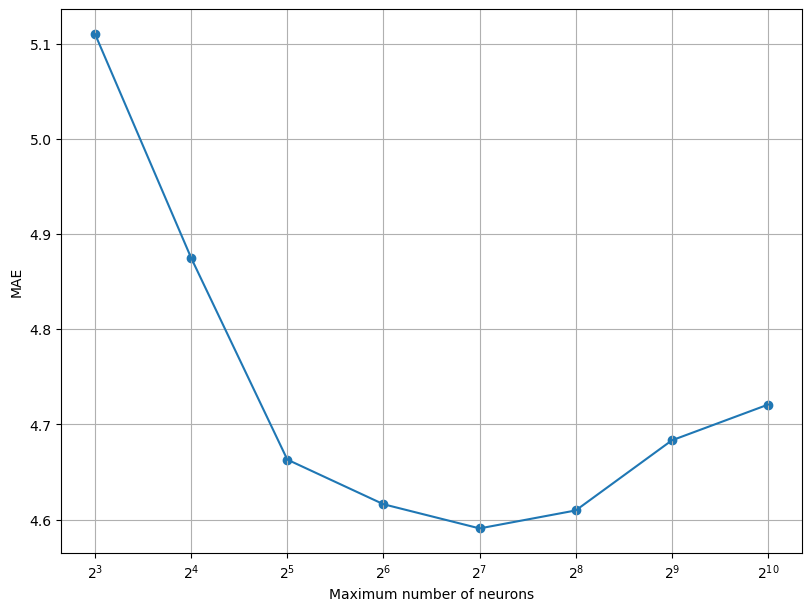

In [12]:
cv16f_neurons_avg_results = [
    np.mean(
        get_avg_score(
            cv16f_reg_results, neurons, target="neurons", metric="mae", score="test"
        )
    )
    for neurons in max_neurons
]
x = list(map(int, max_neurons))
plot_results(x, cv16f_neurons_avg_results, "Maximum number of neurons", log=True)

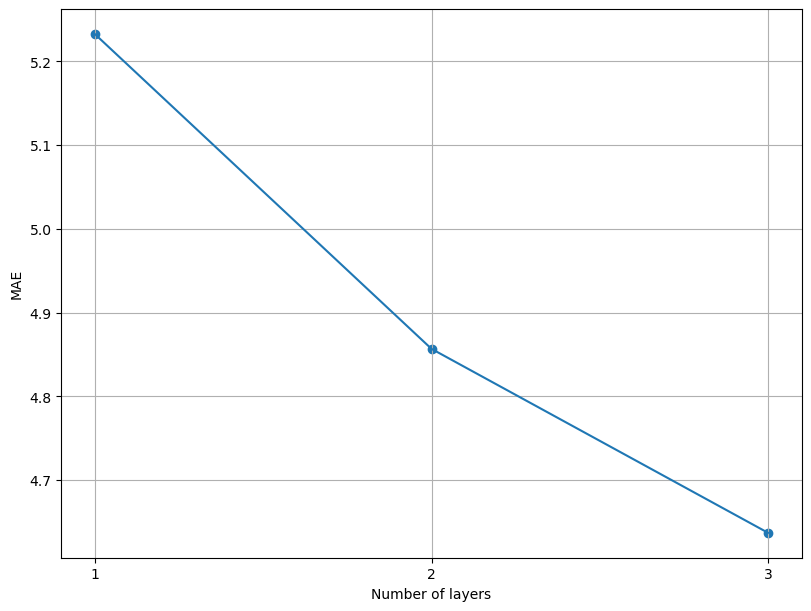

In [13]:
cv16f_layers_avg_results = [
    np.mean(
        get_avg_score(
            cv16f_reg_results, layers, target="layers", metric="mae", score="test"
        )
    )
    for layers in range(1, 4)
]
x = range(1, 4)
plot_results(x, cv16f_layers_avg_results, "Number of layers", log=False, intx=True)

In [14]:
cv16f_osnr_avg_results = [
    np.mean(
        get_avg_score(
            cv16f_reg_results, osnr, target="osnr", metric="mae", score="test"
        )
    )
    for osnr in ["osnr", "wo_osnr"]
]
print(f"With OSNR  Without OSNR")
print(f"{cv16f_osnr_avg_results[0]:.3f}       {cv16f_osnr_avg_results[1]:.3f}")

With OSNR  Without OSNR
4.232       5.235


### Sort models by score

In [15]:
# Find better model by test score
def get_better_models(results, metric="mae", score="test"):
    scores = []
    for activations in hidden_layers:
        for neurons in max_neurons:
            for osnr in osnr_lst:
                act_fn_name = "".join([s[0] for s in activations])
                coll = results[act_fn_name][neurons][osnr][metric][score]
                if isinstance(coll, defaultdict):
                    continue
                score_value = np.mean(coll)
                scores.append((score_value, [act_fn_name, neurons, osnr]))
    scores.sort(key=lambda x: x[0])
    return pl.dataframe.DataFrame(scores)

In [16]:
cv16f_better_models_df = get_better_models(
    cv16f_reg_results, metric="mae", score="test"
)
cv16f_better_models_df.head(10)

column_0,column_1
f64,list[str]
2.80612,"[""tst"", ""512"", ""osnr""]"
2.807177,"[""tss"", ""32"", ""osnr""]"
2.818996,"[""stt"", ""256"", ""osnr""]"
2.83914,"[""tss"", ""256"", ""osnr""]"
2.845752,"[""tst"", ""128"", ""osnr""]"
2.879023,"[""rtt"", ""256"", ""osnr""]"
2.881343,"[""tss"", ""64"", ""osnr""]"
2.891847,"[""tss"", ""1024"", ""osnr""]"
2.893098,"[""rrs"", ""256"", ""osnr""]"


## GKM

In [17]:
if GOOGLE_COLAB:
    cv16g_file = "counting_vectors_16g.csv"
else:
    cv16g_file = "../../Databases/16GBd/counting_vectors_16g.csv"

cv16g = pl.read_csv(cv16g_file, has_header=False, dtypes=[pl.Float64])
# Show the original dataframe
cv16g

column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.7904,0.1593,0.0307,0.0155,0.0028,0.0011,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,16.3,15.5
0.7958,0.1501,0.0311,0.0169,0.0036,0.0019,0.0004,0.0001,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7867,0.1636,0.0306,0.0149,0.0026,0.0012,0.0002,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7893,0.1616,0.0285,0.0164,0.0021,0.0019,0.0001,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7918,0.1496,0.0331,0.0175,0.0055,0.002,0.0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7948,0.1564,0.029,0.017,0.0023,0.0004,0.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.7682,0.1669,0.0362,0.0205,0.0044,0.0028,0.0005,0.0003,0.0001,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8038,0.1516,0.0279,0.0132,0.002,0.0011,0.0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5
0.8013,0.1537,0.029,0.0125,0.0024,0.0009,0.0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,15.5


In [18]:
# Shuffle the dataframe
cv16g_shuffled = cv16g.sample(n=len(cv16g), shuffle=True, seed=1036681523)
print(cv16g_shuffled)

shape: (680, 18)
┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0.8876   ┆ 0.0925   ┆ 0.0125   ┆ 0.0061   ┆ … ┆ 0.0       ┆ 0.0       ┆ 21.3      ┆ 15.5      │
│ 0.883    ┆ 0.1012   ┆ 0.0108   ┆ 0.0048   ┆ … ┆ 0.0       ┆ 0.0       ┆ 15.3      ┆ 17.0      │
│ 0.87     ┆ 0.1126   ┆ 0.0122   ┆ 0.0049   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 16.0      │
│ 0.999    ┆ 0.001    ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 28.3      ┆ 17.0      │
│ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 0

In [19]:
# Extract 10% of the data to use later for "production" testing
cv16g_prod = cv16g_shuffled[: int(len(cv16g_shuffled) * 0.1)]
print(cv16g_prod)

shape: (68, 18)
┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ column_1 ┆ column_2 ┆ column_3 ┆ column_4 ┆ … ┆ column_15 ┆ column_16 ┆ column_17 ┆ column_18 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0.8876   ┆ 0.0925   ┆ 0.0125   ┆ 0.0061   ┆ … ┆ 0.0       ┆ 0.0       ┆ 21.3      ┆ 15.5      │
│ 0.883    ┆ 0.1012   ┆ 0.0108   ┆ 0.0048   ┆ … ┆ 0.0       ┆ 0.0       ┆ 15.3      ┆ 17.0      │
│ 0.87     ┆ 0.1126   ┆ 0.0122   ┆ 0.0049   ┆ … ┆ 0.0       ┆ 0.0       ┆ 16.3      ┆ 16.0      │
│ 0.999    ┆ 0.001    ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 28.3      ┆ 17.0      │
│ …        ┆ …        ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 1.

In [20]:
# Use the rest of the data for normal testing
cv16g_new = cv16g_shuffled[int(len(cv16g_shuffled) * 0.1) :]

### Hyperparameters evaluation

In [21]:
try:
    cv16g_reg_results = sofa.load_hdf5(f"{ROOT}/cv16g_reg_results.h5")
except:
    print("Error loading from file, creating a new dictionary")
    cv16g_reg_results = defaultdict(
        defaultdict(defaultdict(defaultdict().copy).copy).copy
    )

# Evaluate
for activations in hidden_layers:
    for neurons in max_neurons:
        for osnr in osnr_lst:
            args = {
                "data": cv16g_new,
                "data_prod": cv16g_prod,
                "n_splits": 5,
                "max_neurons": int(neurons),
                "activations": activations,
                "use_osnr": True if osnr == "osnr" else False,
            }
            act_fn_name = "".join([s[0] for s in activations])
            if cv16g_reg_results[act_fn_name][neurons][osnr] == defaultdict():
                # Get results
                results = test_estimation_model(**args)
                # Serialize model
                results["model"] = [
                    utils.serialize_keras_object(model) for model in results["model"]
                ]
                # Save serialized model for serialization
                cv16g_reg_results[act_fn_name][neurons][osnr] = results
                # Save results with serialized model
                print("Saving results...")
                sofa.save_hdf5(cv16g_reg_results, f"{ROOT}/cv16g_reg_results.h5")
                print("Results saved!")

### Results

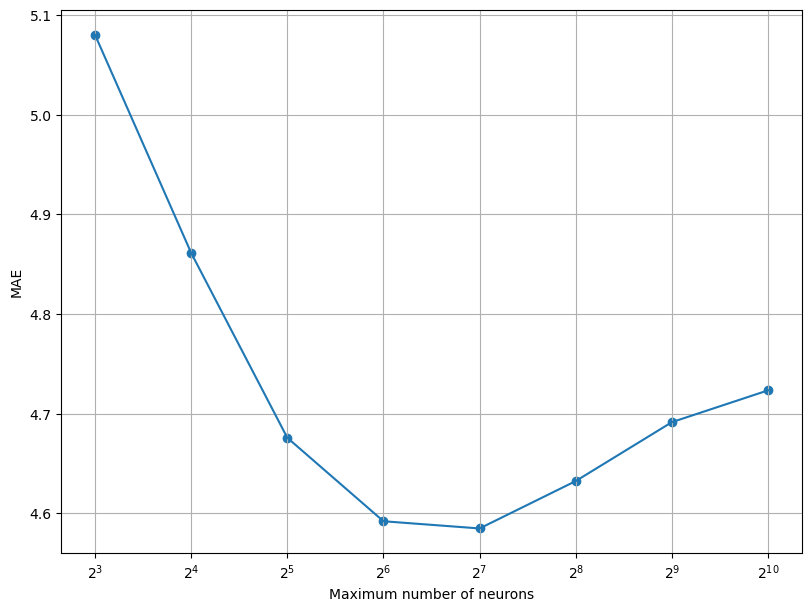

In [22]:
cv16g_neurons_avg_results = [
    np.mean(
        get_avg_score(
            cv16g_reg_results, neurons, target="neurons", metric="mae", score="test"
        )
    )
    for neurons in max_neurons
]
x = list(map(int, max_neurons))
plot_results(x, cv16g_neurons_avg_results, "Maximum number of neurons", log=True)

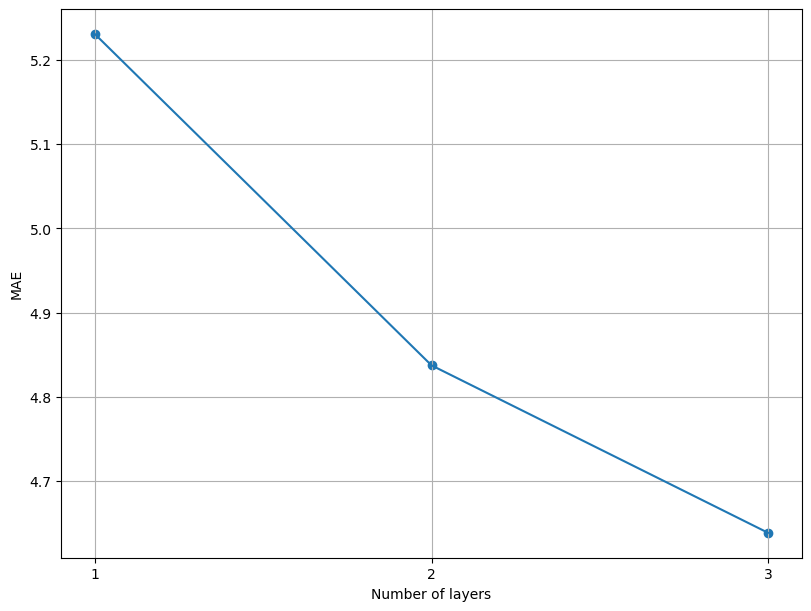

In [23]:
cv16g_layers_avg_results = [
    np.mean(
        get_avg_score(
            cv16g_reg_results, layers, target="layers", metric="mae", score="test"
        )
    )
    for layers in range(1, 4)
]
x = range(1, 4)
plot_results(x, cv16g_layers_avg_results, "Number of layers", log=False, intx=True)

In [24]:
cv16g_osnr_avg_results = [
    np.mean(
        get_avg_score(
            cv16g_reg_results, osnr, target="osnr", metric="mae", score="test"
        )
    )
    for osnr in ["osnr", "wo_osnr"]
]
print(f"Con OSNR  Sin OSNR")
print(f"{cv16g_osnr_avg_results[0]:.3f}       {cv16g_osnr_avg_results[1]:.3f}")

Con OSNR  Sin OSNR
4.232       5.228


### Sort models by score

In [26]:
cv16g_better_models_df = get_better_models(
    cv16g_reg_results, metric="mae", score="test"
)
cv16g_better_models_df.head(10)

column_0,column_1
f64,list[str]
2.756541,"[""tst"", ""128"", ""osnr""]"
2.822385,"[""tst"", ""64"", ""osnr""]"
2.830602,"[""rtt"", ""64"", ""osnr""]"
2.837135,"[""tss"", ""64"", ""osnr""]"
2.842542,"[""rss"", ""32"", ""osnr""]"
2.852606,"[""rtt"", ""512"", ""osnr""]"
2.871675,"[""rst"", ""128"", ""osnr""]"
2.873786,"[""tst"", ""512"", ""osnr""]"
2.886047,"[""rrs"", ""256"", ""osnr""]"
